In [2]:
import numpy as np
import scipy.io as io
import h5py
import deepdish as dd
import os

import skimage
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas as pd
sns.set(style="white")
sns.set_color_codes("pastel")

if 1:
    import plotly.plotly as py

In [3]:
#Lets choose a monkey
Monkey  = 'M1'
h5path = '../../../V4pydata/H5data/M1'
fname = os.listdir(h5path)
print 'files from Monkey %s: ' % Monkey
fname

files from Monkey M1: 


['bucky090910.h5',
 'bucky090910_mergedpeaks.h5',
 'bucky090910_unmergedpeaks.h5']

In [4]:
#Lets choose a session/file
thisfile = fname[0]
print 'lez look at file: %s' % thisfile[:-3]

lez look at file: bucky090910


In [5]:
### Read in using deepdish
dat = dd.io.load(h5path+'/'+ thisfile)

print 'These are the 2 main fields of this structure:'
print dat.keys()
print 
nneurons = np.size(dat['spikes'].keys())
print 'It has %.0f neurons' % nneurons
print
print 'These are the features of eye movement:'
print np.array(dat['eyes'][0].keys())

These are the 2 main fields of this structure:
['eyes', 'spikes']

It has 142 neurons

These are the features of eye movement:
['imname' 'fix_offset' 'fixation' 'out_sac_dur' 'impath' 'trial'
 'in_sac_dur' 'fix_onset' 'col' 'row']


running fo monkey: M1
for file: bucky090910.h5


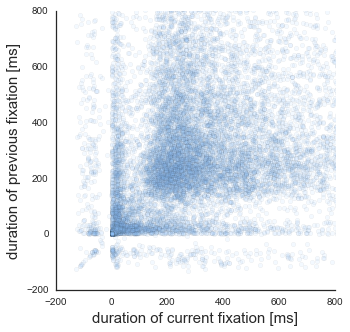

In [6]:
#let's look at fixation durations

print 'running fo monkey: ' + Monkey
print 'for file: ' + thisfile
    
fix_onset_times = np.array([dat['eyes'][fix]['fix_onset'] for fix in dat['eyes']])
fix_offset_times = np.array([dat['eyes'][fix]['fix_offset'] for fix in dat['eyes']])

fix_dur = fix_offset_times-fix_onset_times

mpl_fig_obj, ax = plt.subplots(figsize=(5, 5))

cur_fix_dur = fix_dur[1:]*1000
prev_fix_dur = fix_dur[0:-1]*1000

plt.scatter(cur_fix_dur , prev_fix_dur, s=20,  alpha=0.1)

plt.xlabel('duration of current fixation [ms]',fontsize=15)
plt.ylabel('duration of previous fixation [ms]',fontsize=15)
#plt.title( Monkey + '; file:' + thisfile[:-3], fontsize=15)
plt.xlim([-200,800])
plt.ylim([-200,800])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#run if you want plotly
#py.iplot_mpl(mpl_fig_obj)



the highest firing neuron is neuron '3301' with a firing rate of 30.2 Spks/s


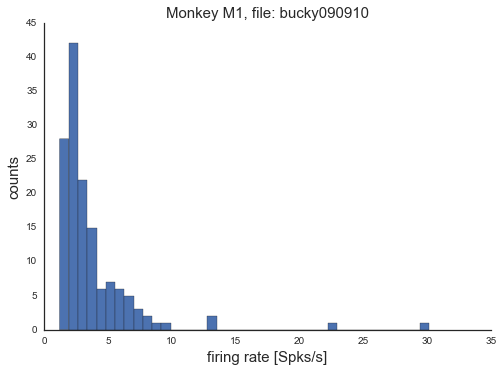

In [7]:
#Lets look at a particular neuron, how about the one that fires the most?

spikes = dat['spikes']
neuron_list = spikes.keys()
firing_rates = np.array([np.size(spikes[j])/(spikes[j][-1]-spikes[j][0]) for i,j in enumerate(spikes)])
idx_maxFR = np.argmax(firing_rates)
neuronid = neuron_list[idx_maxFR]
print 'the highest firing neuron is neuron \'%s\' with a firing rate of %.1f Spks/s' % (neuronid,firing_rates[idx_maxFR])

mpl_fig_obj = plt.figure()
plt.hist(firing_rates, 40)
plt.xlabel('firing rate [Spks/s]',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.title('Monkey %s, file: %s' % (Monkey, thisfile[:-3]),fontsize=15)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#py.iplot_mpl(mpl_fig_obj)



In [8]:
# let's define some functions. move these to a script file and import
def get_event_times_restict(fix_onset, fix_offset, fix_durs = [300,700], event = 'fix_onset'):
    fix_durs = np.array(fix_durs)/1000.
    fix_dur = np.array([(fix_offset[fix_offset>i]-i)[0] for i in fix_onset])
    val_len_fix = np.intersect1d(np.where(fix_dur>fix_durs [0]),np.where(fix_dur<fix_durs[1]))
    if event == 'fix_onset':
        event_times_restr = fix_onset[val_len_fix]
    elif event == 'fix_offset':
        event_times_restr = fix_offset[val_len_fix]
    return event_times_restr

def make_psth(spike_times, event_times, t_window=[-100,200], bin_size=10., plot_psth=1, title = 'PSTH', fix_durs = [], vlinepos = [], Color = 'b'):
    
    fix_durs = np.array(fix_durs)
    t_window = np.array(t_window)
    time_res = 0.001*bin_size
    n_max_seconds = spike_times[-1]
    n_min_seconds = spike_times[0]
    event_times = event_times[event_times < n_max_seconds]
    event_times = event_times[event_times > n_min_seconds]
    bins = np.arange(np.floor(n_min_seconds),np.ceil(n_max_seconds),time_res)

    [spike_counts, bin_edges] = np.histogram(spike_times, bins)
    [event_counts, bin_edges] = np.histogram(event_times, bins)
    idx_event =  np.where(event_counts > 0)[0]
    
    psth = np.array([(spike_counts[(i+t_window[0]/bin_size):(i+t_window[1]/bin_size)]) for i in idx_event])
    
    #plot
    if plot_psth==1:
        mean_psth = np.mean(psth,axis=0)/time_res
        std_psth = np.sqrt(np.var(psth,axis=0))/time_res
        sem_psth = std_psth/np.shape(mean_psth)[0]
        xx = np.linspace(t_window[0], t_window[1], num=np.diff(t_window)/bin_size)
        n_seconds = (spike_times[-1]-spike_times[0])
        n_spikes = np.size(spike_times)
        firing_rate = (n_spikes/n_seconds)
        
        fig.suptitle(title, fontsize=14, fontweight='bold')
        ax = fig.add_subplot(111)
        fig.subplots_adjust(top=0.85)
        
        #ax.plot([0,0],[np.min(mean_psth),np.max(mean_psth)], color='k')
        ax.plot([0,0],[0,np.max(mean_psth)], color='k')
        if np.size(fix_durs)>0:
            if np.shape(vlinepos)[0]>0:
                ypos = vlinepos[0]
            else:
                ypos = np.min(mean_psth)-np.abs(min(mean_psth))/2.
            ax.plot(fix_durs,ypos*np.ones(2), color=Color, ls ='-',lw=4)
            ax.annotate('%s: %.0f fixations' % (str(interv),np.shape(psth)[0]), xy=(fix_durs[1], ypos), xytext=(fix_durs[1]+15, ypos))

        ax.plot(xx, mean_psth, color=Color,lw=2)
        ax.plot(xx, mean_psth+sem_psth, color=Color, ls =':')
        ax.plot(xx, mean_psth-sem_psth, color=Color, ls =':')
        ax.legend(['event'])
        ax.set_title('Average firing rate %.1f Spks/s' % (firing_rate))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('time [ms]')
        ax.set_ylabel('spikes per second [spks/s]') 
    
    return psth

def make_raster(spike_times, event_times, t_window=[-100,200], bin_size=10., title = 'raster plot', fix_durs = [120,600], sort=1):
    t_window = np.array(t_window)
    time_res = 0.001*bin_size
    n_max_seconds = spike_times[-1]
    n_min_seconds = spike_times[0]
    event_times = event_times[event_times < n_max_seconds]
    event_times = event_times[event_times > n_min_seconds]
    bins = np.arange(np.floor(n_min_seconds),np.ceil(n_max_seconds),time_res)

    [spike_counts, bin_edges] = np.histogram(spike_times, bins)
    [event_counts, bin_edges] = np.histogram(event_times, bins)
    idx_event =  np.where(event_counts > 0)[0]
    
    plt.subplots(figsize=(5, 7))
    psth = np.array([(spike_counts[(i+t_window[0]/bin_size):(i+t_window[1]/bin_size)]) for i in idx_event])
    
    psth_sorted = psth[np.sum(psth, axis=1).argsort()]
    if sort:
        plt.imshow(psth_sorted, aspect='auto', interpolation='none')#, extent=(0.5,10.5,0.5,10.5))
    else:
        plt.imshow(psth, aspect='auto', interpolation='none')#, extent=(0.5,10.5,0.5,10.5))
    
    plt.ylabel('trials')
    plt.xlabel('time [ms]')
    
    ax = plt.gca()
    aux = np.arange(t_window[0],t_window[1],bin_size*10)
    aux = [str(i) for i in aux]
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks(np.arange(0,(t_window[1]-t_window[0])/bin_size,10), aux)
    plt.title('fixation duration interval: ' + str(fix_durs))
    plt.axvline((-t_window[0])/bin_size, color='r', linestyle='solid')
    plt.show()
    
    return psth


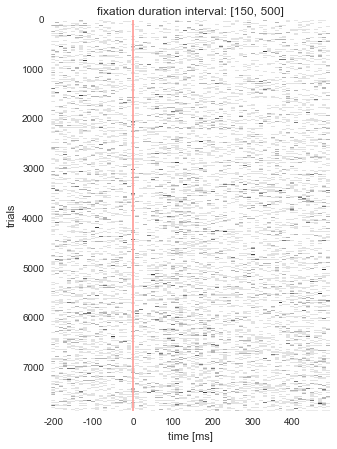

In [9]:
#let's plot a raster centered at fixation onset, try setting sort to 1 or 0
spike_times = dat['spikes'][neuronid]
interv = [150,500]
event_times =  get_event_times_restict(fix_onset_times, fix_offset_times, fix_durs = interv, event = 'fix_onset')
raster = make_raster(spike_times, event_times, t_window=[-200,500], bin_size=10, fix_durs = interv, sort=0)



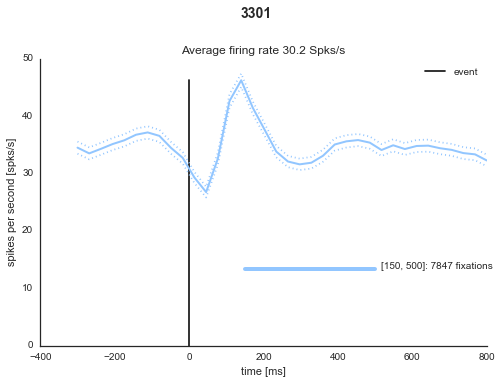

In [13]:
# now the psth
interv = [150,500]
event_times =  get_event_times_restict(fix_onset_times, fix_offset_times, interv, 'fix_onset')
fig = plt.figure()
raster = make_psth(spike_times, event_times, t_window=[-300,800], bin_size=30, fix_durs = interv, title = neuronid)


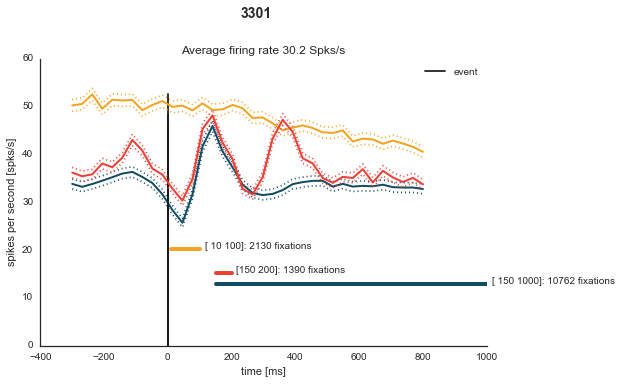

In [12]:
#and we can overlap several psths for diferent restrictions on the fix_duration

#but we need some colors
Colors = ['#F5A21E','#134B64','#EF3E34','#02A68E','#FF07CD']
INTERVALS = np.array([[10,100],[150,1000],[150,200]])
fig = plt.figure()
for i, interv in enumerate(INTERVALS):
    event_times =  get_event_times_restict(fix_onset_times, fix_offset_times, interv, 'fix_onset')
    raster = make_psth(spike_times, event_times, t_window=[-300,800], bin_size = 30, fix_durs = interv, Color = Colors[i], title = neuronid)

